<a href="https://colab.research.google.com/github/AtriSaxena/Tensorflow-2.X-Zero2Mastery/blob/main/07_transfer_learning_part3_ScalingUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tensorflow learning with tensorflow part3: ScalingUp



In [ ]:
!nvidia-smi

Sun Nov 28 12:28:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-11-28 12:28:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-11-28 12:28:13 (51.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
#Import from helper_function.py 

from helper_functions import plot_loss_curves, unzip_data, create_tensorboard_callback, walk_through_dir 

## Let's get all classes(101) 10 % of data. 


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2021-11-28 12:28:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.152.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   189MB/s    in 8.4s    

2021-11-28 12:28:24 (184 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gnocchi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/donuts'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'.
There are 0 directories and 75 images in '101_food_classes_10_

## Load the data 

In [ ]:
import tensorflow as tf

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"
IMAGE_SHAPE = (224,224) 
BATCH_SIZE = 32 

In [ ]:
#Load data from directory as tf Image 

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
                                                                            label_mode = "categorical", 
                                                                            image_size = IMAGE_SHAPE,
                                                                            shuffle=True)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                label_mode="categorical", 
                                                                image_size = IMAGE_SHAPE, 
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
#Prepare Data Augmentation Layers 
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing

augmentation_layer = tf.keras.Sequential([
                                      preprocessing.RandomCrop(224,224),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomWidth(0.2)
], name = "Augmentation_layer")



In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False, 
                                                  classes = len(train_data_10_percent.class_names),
                                                  )
base_model.trainable = False 

inputs = tf.keras.layers.Input(shape=(224,224,3))
x = augmentation_layer(inputs)
x = base_model(x, training = False)
x = tf.keras.layers.GlobalAveragePooling2D(name= "global_average_pooling")(x)
output_layer = tf.keras.layers.Dense(101, activation="softmax")(x)

Scaled_model = tf.keras.Model(inputs, output_layer)

Scaled_model.compile(loss = "categorical_crossentropy", 
                     optimizer = tf.keras.optimizers.Adam(), 
                     metrics=["accuracy"])

Scaled_model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Augmentation_layer (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                              

In [ ]:
initial_epochs = 5
Scaled_model_history = Scaled_model.fit(train_data_10_percent, 
                                        epochs=initial_epochs, 
                                        validation_data = test_data, 
                                        steps_per_epoch = len(train_data_10_percent),
                                        validation_steps = int(0.15 * len(test_data)),
                                        callbacks = [create_tensorboard_callback(dir_name="transfer_learning", experiment_name="Scaled_model")])

Saving TensorBoard log files to: transfer_learning/Scaled_model/20211128-122916
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


237/237 [==============================] - 137s 508ms/step - loss: 3.4710 - accuracy: 0.2515 - val_loss: 2.7181 - val_accuracy: 0.3750
Epoch 2/5
237/237 [==============================] - 100s 420ms/step - loss: 2.3621 - accuracy: 0.4598 - val_loss: 2.2302 - val_accuracy: 0.4629
Epoch 3/5
237/237 [==============================] - 89s 375ms/step - loss: 1.9989 - accuracy: 0.5234 - val_loss: 2.0710 - val_accuracy: 0.4791
Epoch 4/5
237/237 [==============================] - 80s 335ms/step - loss: 1.7838 - accuracy: 0.5669 - val_loss: 1.9902 - val_accuracy: 0.4836
Epoch 5/5
237/237 [==============================] - 82s 342ms/step - loss: 1.6291 - accuracy: 0.5992 - val_loss: 1.9458 - val_accuracy: 0.4952


In [ ]:
Scaled_model.evaluate(test_data)

790/790 [==============================] - 104s 132ms/step - loss: 1.7240 - accuracy: 0.5497


[1.7240475416183472, 0.5496633648872375]

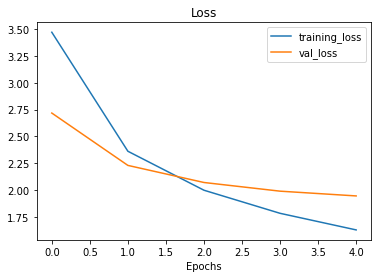

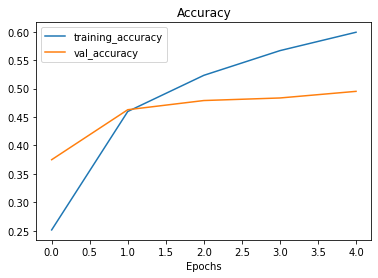

In [ ]:
plot_loss_curves(Scaled_model_history)

> what to these graphs suggest? 

According to the graphs it seems like our model is not generalizing well on validation data. It pretty sure our model is overfitting. 

In [ ]:
for layer_no, layer in enumerate(Scaled_model.layers[2].layers): 
  print(layer_no, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

## Fine tune the model 

In [ ]:
base_model.trainable = True 

for layer in base_model.layers[:-5]: 
  layer.trainable = False 

for layer_no, layer in enumerate(base_model.layers): 
  print(layer_no, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:

Scaled_model.compile(loss = "categorical_crossentropy", 
                     optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                     metrics=["accuracy"])

Scaled_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 Augmentation_layer (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 910,821
Non-trainab

In [ ]:
Scaled_model_Finetune_history = Scaled_model.fit(train_data_10_percent, 
                                                 epochs = initial_epochs+5, 
                                                 initial_epoch = Scaled_model_history.epoch[-1],
                                                 steps_per_epoch = len(train_data_10_percent),
                                                 validation_steps = int(0.15 * len(test_data)),
                                                 validation_data = test_data)

Epoch 5/10
237/237 [==============================] - 84s 317ms/step - loss: 1.3765 - accuracy: 0.6446 - val_loss: 1.8895 - val_accuracy: 0.5016
Epoch 6/10
237/237 [==============================] - 70s 292ms/step - loss: 1.2772 - accuracy: 0.6650 - val_loss: 1.8800 - val_accuracy: 0.5090
Epoch 7/10
237/237 [==============================] - 70s 295ms/step - loss: 1.1710 - accuracy: 0.6861 - val_loss: 1.8515 - val_accuracy: 0.5159
Epoch 8/10
237/237 [==============================] - 69s 290ms/step - loss: 1.1005 - accuracy: 0.7142 - val_loss: 1.8362 - val_accuracy: 0.5185
Epoch 9/10
237/237 [==============================] - 64s 269ms/step - loss: 1.0511 - accuracy: 0.7201 - val_loss: 1.8113 - val_accuracy: 0.5286
Epoch 10/10
237/237 [==============================] - 65s 272ms/step - loss: 1.0073 - accuracy: 0.7353 - val_loss: 1.8629 - val_accuracy: 0.5191


In [ ]:
finetune_result = Scaled_model.evaluate(test_data)
finetune_result

790/790 [==============================] - 104s 132ms/step - loss: 1.6018 - accuracy: 0.5795


[1.6018332242965698, 0.5794851779937744]

In [ ]:
import matplotlib.pyplot as plt

#Let's create a function to compare training histories
def compare_history(original_history, new_history, initial_epochs =5): 
  """
  Compare two tensorflow history objects

  """
  #Get original history measurements 
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  #Combine original history 
  total_acc = acc+ new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  #Make plot for accuracy
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training accuracy")
  plt.plot(total_val_acc, label = "Validation_accuracy") 
  plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(), label ="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  #Make plot for loss 
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training loss")
  plt.plot(total_val_loss, label = "Validation_loss") 
  plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(), label ="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation loss")

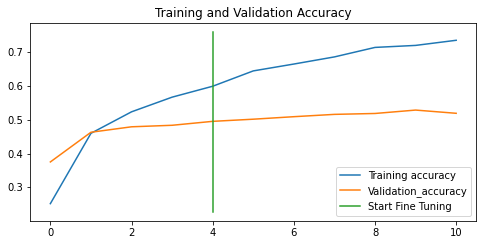

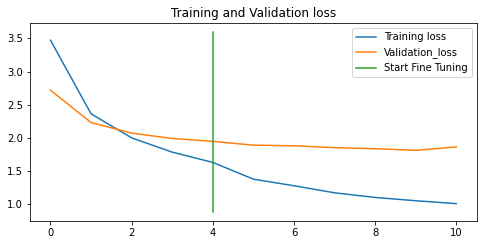

In [ ]:
compare_history(original_history=Scaled_model_history, new_history = Scaled_model_Finetune_history)

## Saving and loading our model 



In [ ]:
Scaled_model.save("101_classes_food_finetuned_Model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
loaded_model = tf.keras.models.load_model("101_classes_food_finetuned_Model.h5")

# Doing prediction on test Data


In [ ]:
pred_probs = Scaled_model.predict(test_data, verbose=1)
len(pred_probs)

790/790 [==============================] - 99s 123ms/step


25250

In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
print(pred_probs[0], len(pred_probs[0]))

[3.40977967e-01 6.02265172e-05 2.61234283e-01 6.58190800e-08
 8.70577787e-06 6.63382536e-07 1.19994766e-04 9.83463542e-06
 2.84649786e-02 1.30628829e-03 1.08282495e-06 1.34417369e-05
 1.65465288e-03 5.91100331e-07 5.40613849e-03 1.96565944e-03
 1.28948277e-05 6.06927497e-04 1.05939910e-03 4.20382094e-06
 1.39578406e-04 1.75959522e-05 2.77915096e-04 1.68305094e-04
 3.41241452e-04 1.49077081e-04 3.01560096e-04 1.56848873e-05
 6.84167147e-02 2.09817267e-03 2.18926584e-06 5.90367476e-04
 3.43398366e-04 1.86898774e-07 3.58606200e-03 1.72583132e-05
 6.40661747e-05 6.31956267e-04 1.35777509e-02 1.14368295e-05
 5.96914208e-04 8.87115719e-04 9.97020281e-04 6.27684221e-06
 2.47192711e-05 6.03438020e-05 4.32920846e-04 9.24182066e-04
 1.91734352e-06 1.49024334e-02 1.69140520e-04 1.56015813e-05
 5.36723025e-02 4.73917834e-03 2.22595791e-05 1.04503660e-02
 1.08640352e-02 7.38779607e-04 6.77683484e-03 7.29767416e-05
 6.82910866e-07 2.15840046e-04 1.94079131e-02 1.42823425e-04
 2.16279135e-04 3.730011

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method

In [ ]:
#We get one prediction probability per class( In our case there are 101 prediction probability)

print(f"Number of prediction probabilities for sample 0:{len(pred_probs[0])}")
print(f"What prediction probility sample looks like\n: {pred_probs[0]}")
print(f"The class with the hightest predicted probability: {tf.argmax(pred_probs[55])}")

Number of prediction probabilities for sample 0:101
What prediction probility sample looks like
: [3.40977967e-01 6.02265172e-05 2.61234283e-01 6.58190800e-08
 8.70577787e-06 6.63382536e-07 1.19994766e-04 9.83463542e-06
 2.84649786e-02 1.30628829e-03 1.08282495e-06 1.34417369e-05
 1.65465288e-03 5.91100331e-07 5.40613849e-03 1.96565944e-03
 1.28948277e-05 6.06927497e-04 1.05939910e-03 4.20382094e-06
 1.39578406e-04 1.75959522e-05 2.77915096e-04 1.68305094e-04
 3.41241452e-04 1.49077081e-04 3.01560096e-04 1.56848873e-05
 6.84167147e-02 2.09817267e-03 2.18926584e-06 5.90367476e-04
 3.43398366e-04 1.86898774e-07 3.58606200e-03 1.72583132e-05
 6.40661747e-05 6.31956267e-04 1.35777509e-02 1.14368295e-05
 5.96914208e-04 8.87115719e-04 9.97020281e-04 6.27684221e-06
 2.47192711e-05 6.03438020e-05 4.32920846e-04 9.24182066e-04
 1.91734352e-06 1.49024334e-02 1.69140520e-04 1.56015813e-05
 5.36723025e-02 4.73917834e-03 2.22595791e-05 1.04503660e-02
 1.08640352e-02 7.38779607e-04 6.77683484e-03 7.

In [ ]:
#Get the pred classes for each label 
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:10]

array([ 0,  0,  0, 42,  2, 78, 29, 46,  9,  0])

Now we got a prediction array of all of our models prediction, to evaluate them we need to compare them to the original test dataset labels. 


In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset 
y_labels = []
for images, labels in test_data.unbatch(): 
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
#how many y labels are there 

print(len(y_labels)) 

25250


# Evaluating our Models predictions 



In [ ]:
finetune_result

[1.6018332242965698, 0.5794851779937744]

In [ ]:
#Lets try sklearn accuracy metrics 

from sklearn.metrics import accuracy_score 

sklearn_accuracy = accuracy_score(y_true = y_labels, y_pred = pred_classes)
sklearn_accuracy

0.5794851485148514

In [ ]:
#Get a list of class_names 
class_names = test_data.class_names 
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  #change (plot x vertically)
  plt.xticks(rotation=70, fontsize = text_size)
  plt.yticks(fontsize= text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

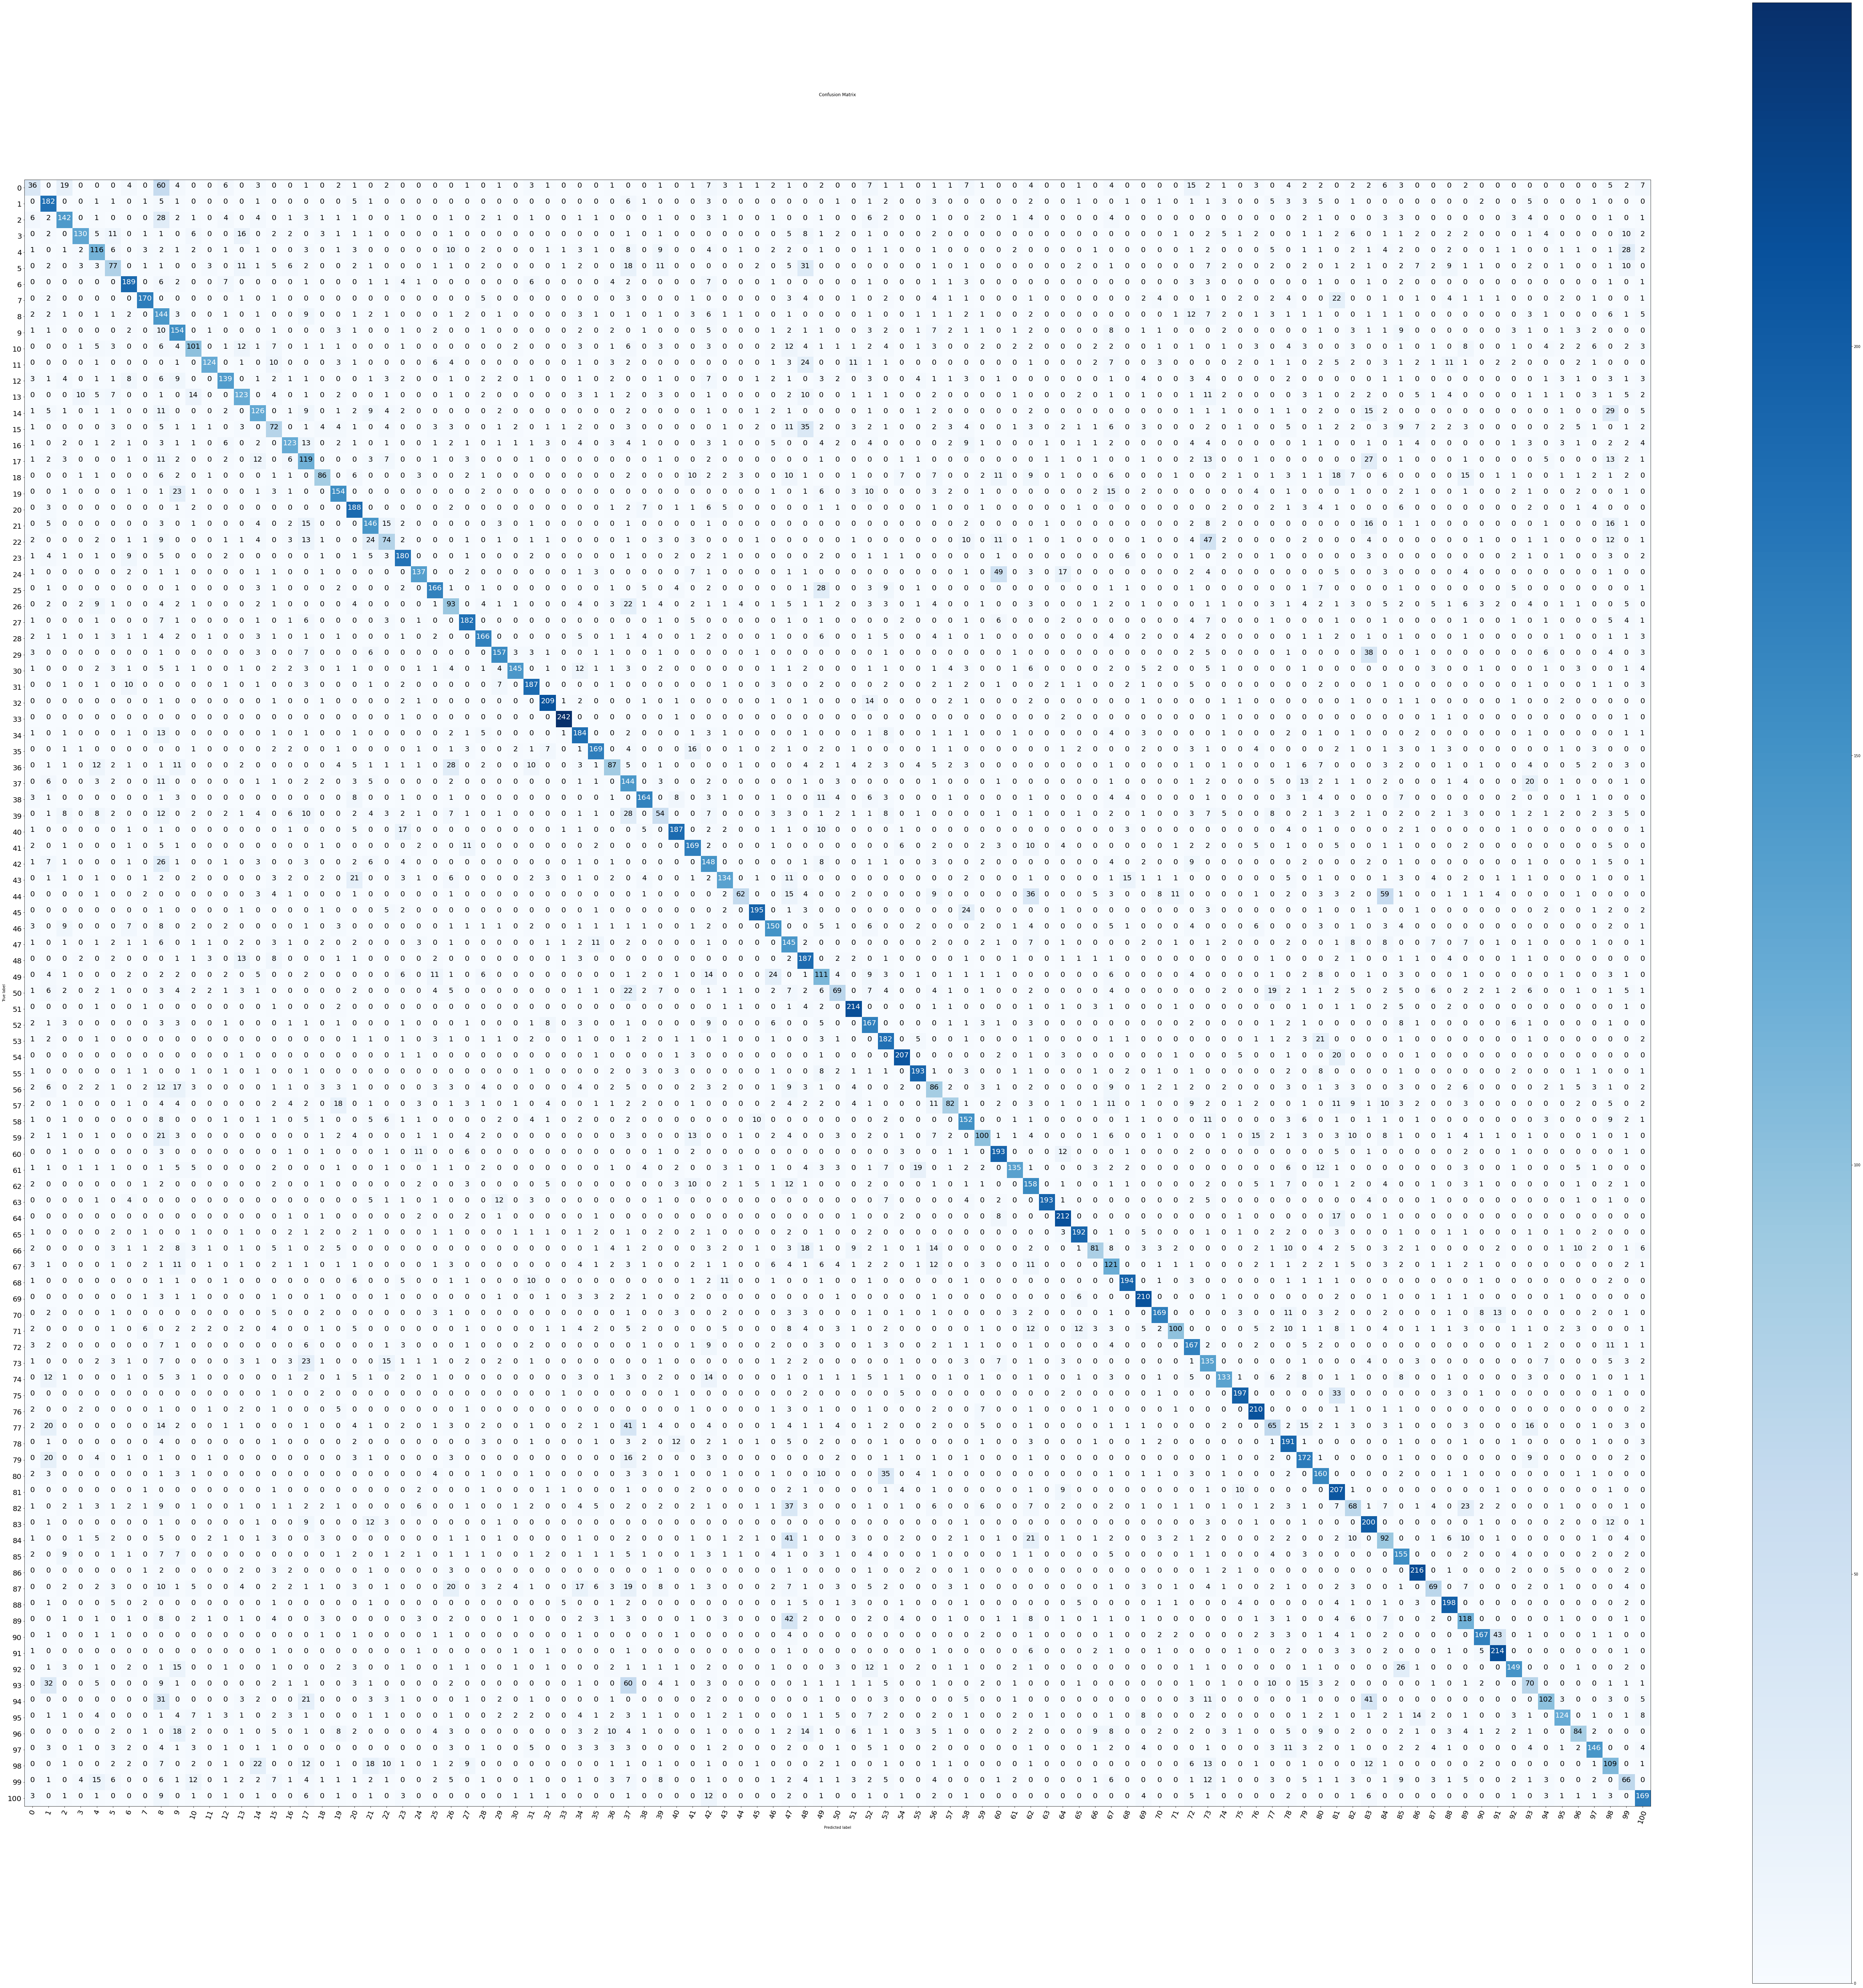

In [ ]:
make_confusion_matrix(y_labels, pred_classes, figsize=(100,100), text_size = 20
                      )

# Let's keep the evalutation going, time for a classificaiton report 

sklearn has a helpful function for acquiring many different classification metrics per class( eg. precision, recall, f1score classfication report) 



In [ ]:
from sklearn.metrics import classification_report 

classification_report(y_true = y_labels, 
                      y_pred = pred_classes)

'              precision    recall  f1-score   support\n\n           0       0.31      0.14      0.20       250\n           1       0.51      0.73      0.60       250\n           2       0.61      0.57      0.59       250\n           3       0.79      0.52      0.63       250\n           4       0.49      0.46      0.48       250\n           5       0.45      0.31      0.37       250\n           6       0.71      0.76      0.73       250\n           7       0.83      0.68      0.75       250\n           8       0.22      0.58      0.32       250\n           9       0.44      0.62      0.51       250\n          10       0.52      0.40      0.45       250\n          11       0.84      0.50      0.62       250\n          12       0.71      0.56      0.62       250\n          13       0.56      0.49      0.53       250\n          14       0.56      0.50      0.53       250\n          15       0.36      0.29      0.32       250\n          16       0.65      0.49      0.56       250\n       

The numbers above give a class by class evalutation of our model's prediction but with so many classes, they are quite hard to understand. 

How about we create a visualization to get better understanding? 

In [ ]:
#Get a dictionary of the classification report 
classification_report_dict = classification_report(y_true = y_labels, 
                      y_pred = pred_classes, output_dict = True)

In [ ]:
classification_report_dict

{'0': {'f1-score': 0.1956521739130435,
  'precision': 0.3050847457627119,
  'recall': 0.144,
  'support': 250},
 '1': {'f1-score': 0.5996705107084019,
  'precision': 0.5098039215686274,
  'recall': 0.728,
  'support': 250},
 '10': {'f1-score': 0.45291479820627806,
  'precision': 0.5153061224489796,
  'recall': 0.404,
  'support': 250},
 '100': {'f1-score': 0.6377358490566037,
  'precision': 0.6035714285714285,
  'recall': 0.676,
  'support': 250},
 '11': {'f1-score': 0.6246851385390428,
  'precision': 0.8435374149659864,
  'recall': 0.496,
  'support': 250},
 '12': {'f1-score': 0.6247191011235954,
  'precision': 0.7128205128205128,
  'recall': 0.556,
  'support': 250},
 '13': {'f1-score': 0.5256410256410257,
  'precision': 0.5642201834862385,
  'recall': 0.492,
  'support': 250},
 '14': {'f1-score': 0.5294117647058824,
  'precision': 0.5575221238938053,
  'recall': 0.504,
  'support': 250},
 '15': {'f1-score': 0.32, 'precision': 0.36, 'recall': 0.288, 'support': 250},
 '16': {'f1-score

lets plot all of our classes F1-Score

In [ ]:
#Create empty dictionary
class_f1_score = {} 

for k, v in classification_report_dict.items(): 
  if k == "accuracy": 
    break
  else: 
    class_f1_score[class_names[int(k)]] = v['f1-score']


class_f1_score


{'apple_pie': 0.1956521739130435,
 'baby_back_ribs': 0.5996705107084019,
 'baklava': 0.5892116182572614,
 'beef_carpaccio': 0.6280193236714976,
 'beef_tartare': 0.4754098360655738,
 'beet_salad': 0.36666666666666664,
 'beignets': 0.7311411992263056,
 'bibimbap': 0.748898678414097,
 'bread_pudding': 0.32,
 'breakfast_burrito': 0.5099337748344371,
 'bruschetta': 0.45291479820627806,
 'caesar_salad': 0.6246851385390428,
 'cannoli': 0.6247191011235954,
 'caprese_salad': 0.5256410256410257,
 'carrot_cake': 0.5294117647058824,
 'ceviche': 0.32,
 'cheese_plate': 0.560364464692483,
 'cheesecake': 0.4089347079037801,
 'chicken_curry': 0.4444444444444444,
 'chicken_quesadilla': 0.6260162601626017,
 'chicken_wings': 0.6573426573426573,
 'chocolate_cake': 0.5583173996175907,
 'chocolate_mousse': 0.3490566037735849,
 'churros': 0.6990291262135921,
 'clam_chowder': 0.6255707762557078,
 'club_sandwich': 0.6916666666666668,
 'crab_cakes': 0.3765182186234817,
 'creme_brulee': 0.7265469061876247,
 'croq

In [ ]:
import pandas as pd 
f1_scores = pd.DataFrame({"class_names": list(class_f1_score.keys()),
                          "f1-score": list(class_f1_score.values())}).sort_values("f1-score")

In [ ]:
f1_scores

,class_names,f1-score
0,apple_pie,0.195652
39,foie_gras,0.273418
99,tuna_tartare,0.291391
82,ravioli,0.302222
77,pork_chop,0.303738
...,...,...
54,hot_and_sour_soup,0.818182
45,frozen_yogurt,0.821053
32,dumplings,0.826087
63,macarons,0.859688


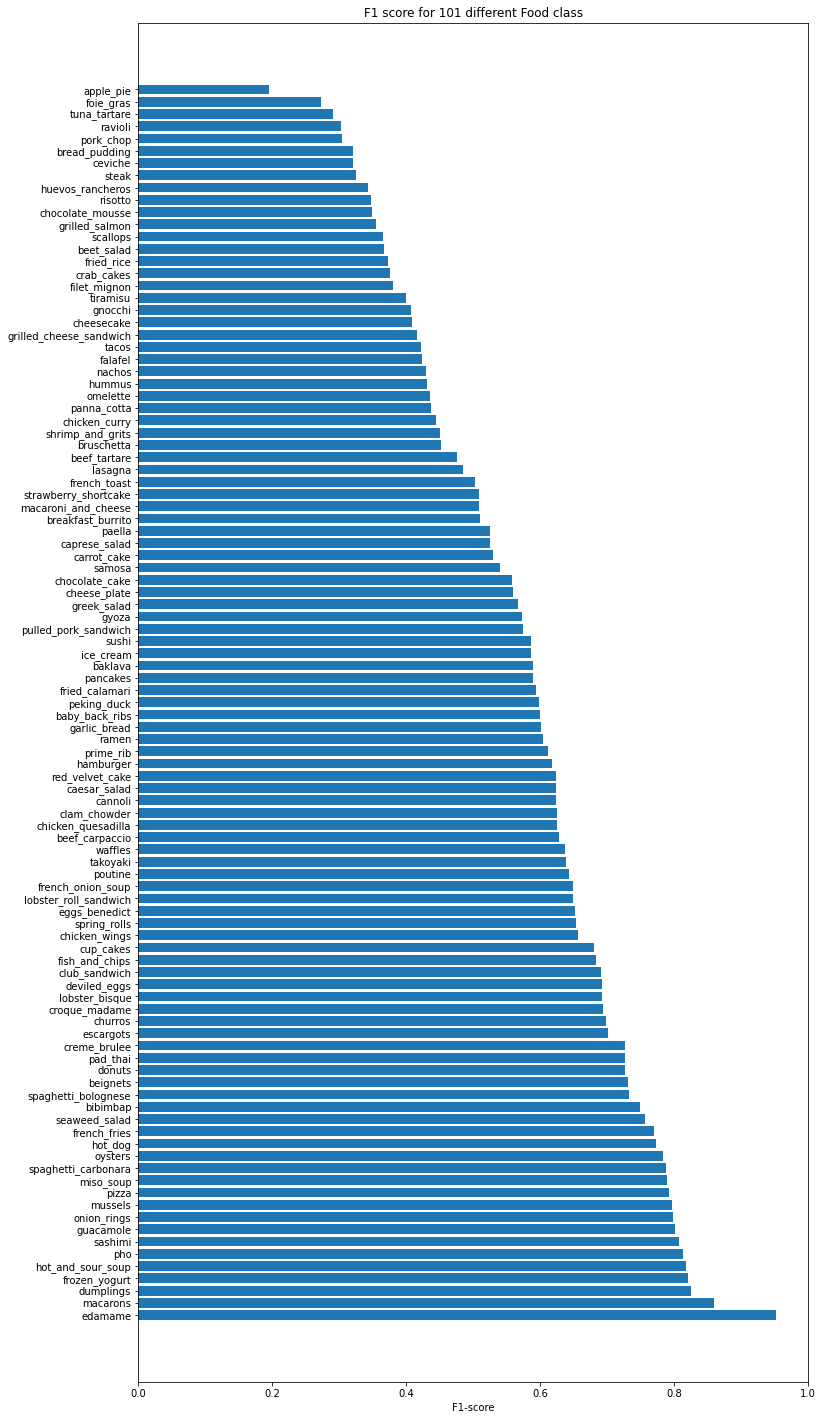

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)

ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 different Food class")
ax.invert_yaxis();

## Visualizing prediction on test images

To visualize our models predictions on our own images, we'll need a function to load and process images, specifically it need to: 

* Read in a target image filepath using tf.io.read_file() 
* Turn the image into a tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize() 
* Scale the image to get all of the pixel values between 0 and 1 if necessary.



In [ ]:
#Create a function to load and prepare images 

def load_and_prep_image(filename, img_shape = 224, scale = True): 
  """ 
  Reads in an image from filename, turns it into a tensor and reshape into 
  specified shape (img_shape, img_shape, color_channel =3)

  Args: 
    filename (str): path to target value
    img_shape (int): height/width dimension of target image size 
    scale (bool): Scale pixel value from 0-255 or 0-1 or not 

  Returns: 
    Image tensor of shape (img_shape, img_shape, 3)

  """

  #Read in the image 
  img = tf.io.read_file(filename) 

  #decode image into tensor 
  img = tf.io.decode_image(img, channels=3)

  #reshape the image 
  img = tf.image.resize(img, [img_shape, img_shape])

  #Scale Yes or no? 
  if scale: 
    return img/255.
  else: 
    return img

Now we have got a function  to load and prepare target images, let's write some code to visualize images, their target labels and predicted labels. 

We will write code to: 
1. Load a few random images from our test dataset. 
2. Make prediction on loaded images. 
3. Plot the original image along with the models predictions, prediction probability and true label.  


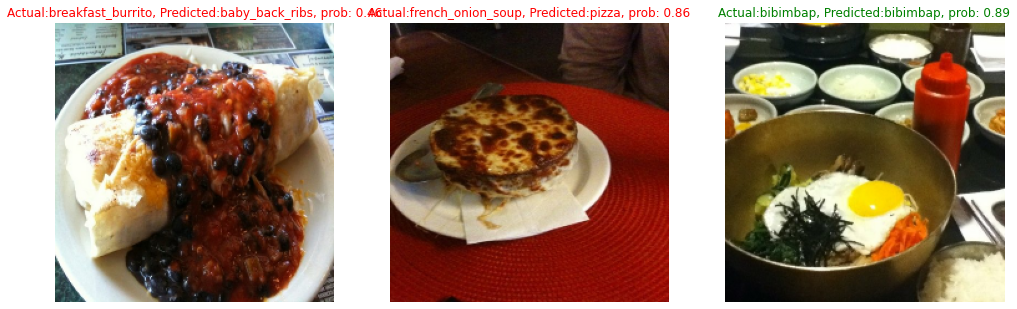

In [ ]:
#Make pred on a series of random image 

import os 
import random 

plt.figure(figsize=(17,14))

for i in range(3): 
  random_class = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + random_class))
  filepath = test_dir + "/" +random_class +  "/" + filename

  #Load image and make predictions 
  img = load_and_prep_image(filepath, img_shape=224, scale=False)
  prediction = Scaled_model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[prediction.argmax()]

  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if random_class == pred_class: 
    title_color = "g"
  else: 
    title_color = "r"
  plt.title(f"Actual:{random_class}, Predicted:{pred_class}, prob: {prediction.max():.2f}", c = title_color)
  plt.axis(False)

## Finding the most wrong predictions

It's a good idea to go through at least 100+ random instances of your model's predictions to get a good feel for how it's doing.

After a while you might notice the model predicting on some images with a very high prediction probability, meaning it's very confident with its prediction but still getting the label wrong.

These most wrong predictions can help to give further insight into your model's performance.

So how about we write some code to collect all of the predictions where the model has output a high prediction probability for an image (e.g. 0.95+) but gotten the prediction wrong.

We'll go through the following steps:

1. Get all of the image file paths in the test dataset using the list_files() method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.

Note: We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# 1. Get the filenames of all of our test data
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

Now we've got all of the test image filepaths, let's combine them into a DataFrame along with:

* Their ground truth labels (y_labels).
* The class the model predicted (pred_classes).
* The maximum prediction probabilitity value (pred_probs.* max(axis=1)).
* The ground truth class names.
* The predicted class names.

In [ ]:
# 2. Create a dataframe out of current prediction data for analysis
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.340978,apple_pie,apple_pie
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.922434,apple_pie,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.244132,apple_pie,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,42,0.175898,apple_pie,french_toast
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,2,0.192642,apple_pie,baklava


In [ ]:
# 3. Is the prediction correct?
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.340978,apple_pie,apple_pie,True
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.922434,apple_pie,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,0,0.244132,apple_pie,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,42,0.175898,apple_pie,french_toast,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,2,0.192642,apple_pie,baklava,False


And now since we know which predictions were right or wrong and along with their prediction probabilities, how about we get the 100 "most wrong" predictions by sorting for wrong predictions and descending prediction probabilties?

In [ ]:
# 4. Get the top 100 wrong examples
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
23631,b'101_food_classes_10_percent/test/strawberry_...,94,83,0.999315,strawberry_shortcake,red_velvet_cake,False
23797,b'101_food_classes_10_percent/test/sushi/16593...,95,86,0.998959,sushi,sashimi,False
18001,b'101_food_classes_10_percent/test/pancakes/10...,72,67,0.997131,pancakes,omelette,False
15826,b'101_food_classes_10_percent/test/macarons/19...,63,29,0.996481,macarons,cup_cakes,False
22511,b'101_food_classes_10_percent/test/spaghetti_b...,90,78,0.994976,spaghetti_bolognese,poutine,False
5530,b'101_food_classes_10_percent/test/chocolate_m...,22,60,0.993744,chocolate_mousse,lobster_bisque,False
10854,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.993666,fried_calamari,onion_rings,False
11642,b'101_food_classes_10_percent/test/garlic_brea...,46,10,0.993307,garlic_bread,bruschetta,False
10847,b'101_food_classes_10_percent/test/fried_calam...,43,68,0.992227,fried_calamari,onion_rings,False
15359,b'101_food_classes_10_percent/test/lobster_rol...,61,53,0.992102,lobster_roll_sandwich,hamburger,False


Very interesting... just by comparing the ground truth classname (y_true_classname) and the prediction classname column (y_pred_classname), do you notice any trends?

It might be easier if we visualize them.

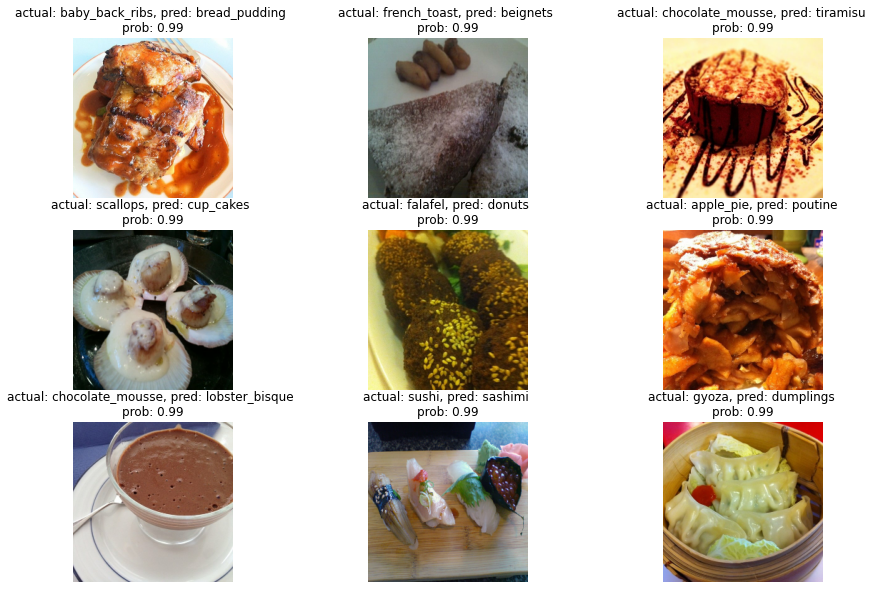

In [ ]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

Going through the model's most wrong predictions can usually help figure out a couple of things:

* **Some of the labels might be wrong** - If our model ends up being good enough, it may actually learning to predict very well on certain classes. This means some images which the model predicts the right label may show up as wrong if the ground truth label is wrong. If this is the case, we can often use our model to help us improve the labels in our dataset(s) and in turn, potentially making future models better. This process of using the model to help improve labels is often referred to as active learning.
* **Could more samples be collected?** - If there's a recurring pattern for a certain class being poorly predicted on, perhaps it's a good idea to collect more samples of that particular class in different scenarios to improve further models.

## Test out the big dog model on test images as well as custom images of food

In [ ]:
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

--2021-11-28 13:07:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 74.125.129.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  81.4MB/s    in 0.2s    

2021-11-28 13:07:06 (81.4 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
# Get custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg']

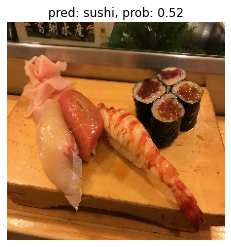

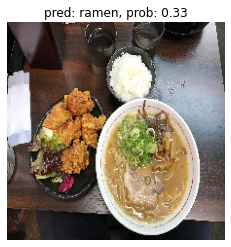

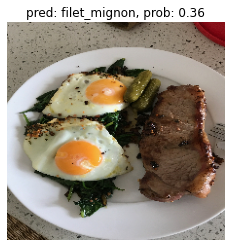

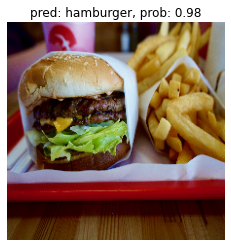

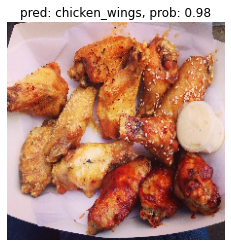

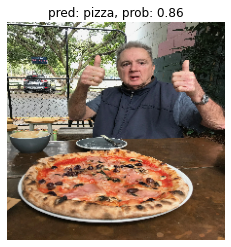

In [ ]:
# Make predictions on custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = Scaled_model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

Two thumbs up! How cool is that?! Our Food Vision model has come to life!

Seeing a machine learning model work on a premade test dataset is cool but seeing it work on your own data is mind blowing.

And guess what... our model got these incredible results (10%+ better than the baseline) with only 10% of the training images.

I wonder what would happen if we trained a model with all of the data (100% of the training data from Food101 instead of 10%)? Hint: that's your task in the next notebook.